In [1]:
import scanpy as sc
import anndata
#import pl
#import tl
import numpy as np
import time as time

# Load Dataset
print("Loading dataset")
filelocation = r"datasets/VBh_converted.h5ad"
#filelocation = "C:/Users/xilef/Desktop/Helmholtz/CantoUnstained_converted.h5ad"
adata = anndata.read_h5ad(filelocation)
print(f"dataset with {len(adata)} cells loaded")

# subsampling (for slow/low memory computers)
#sc.pp.subsample(adata, 0.8)

# removing some channels
for channel in adata.var_names:
    if channel.endswith("-H") or channel == "Time" or channel == "FSC-Width":
        adata.obs[channel]=adata.X[:,adata.var_names == channel]
        adata = adata[:,adata.var_names != channel]

# normalizing
print("Normalizing")
adata.X = np.arcsinh(adata.X / 10)

# calc knn
print("Calculating connectivities")
sc.pp.neighbors(adata, n_neighbors=20)

# calculating louvain clustering of original dataset
print("Calculating louvain clustering")
sc.tl.louvain(adata, resolution=0.5, key_added="louv_05")

print("Done!")

Loading dataset


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


dataset with 129467 cells loaded
Normalizing
Calculating connectivities
Calculating louvain clustering
Done!


**HUMAP function**

In [2]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
import time

import matplotlib.pyplot as plt

def _humap(adata, n_scales: int = 1, 
           subs_mode: str = "knee", 
           factor: float = 0.5, 
           n_knn: 20, 
           copy: bool = False, 
           verbose: bool = False):
    
    # check if knn graph has been calculated beforehand
    assert 'connectivities' in adata.obsp.keys(), "No knn graph found. Calculate with scanpy.tl.neighbors(...)"
    
    if subs_mode=="factor":
        assert factor > 0 and factor < 1, "factor has to be between 0 and 1.0"
    
    # create list with copy of adata as first element
    scales = list()
    scales.append(adata.copy())
    
    for s in range(n_scales):
        if verbose: print(f"-----\nCalculating scale {s}")
        ### getting landmarks
        
        # copy last scale
        speichi = scales[-1].copy()
        
        #sc.pp.neighbors(speichi)
        c = speichi.obsp['connectivities']
        
        # calculate stationary distribution
        pi = calcStationaryDistribution(c)

        ### finding inflection point
        cuttingPoint = findCuttingPoint(pi, mode = subs_mode, factor = factor)

        if verbose: print(f"Cutting data at point {cuttingPoint}")
        
        ### subsample data
        
        # indices of landmarks sorted by probability
        lm_ind = pi.argsort()
        
        speichi = speichi[lm_ind[:cuttingPoint]]

        if verbose: print(f"Calculating scale {s} with {speichi.n_obs} cells")
        
        # plotting
        if verbose:
            plt.plot(pi[pi.argsort()][::-1])
            plt.vlines(cuttingPoint, ymin=0, ymax=max(pi))
            plt.show()
        
        # (re)calculate knn
        sc.pp.neighbors(speichi, n_neighbors=n_knn)
        # calculate umap embedding
        sc.tl.umap(speichi)
        scales.append(speichi)
        
    # removing first element as it is a copy of adata
    scales.pop(0)
    
    # add list of scales to .uns
    adata.uns['HUMAP_scales'] = scales
    return adata if copy else None
    


In [3]:
def calcStationaryDistribution(connectivities):
    
    # transition matrix
    T = connectivities.multiply(csr_matrix(1.0 / np.abs(connectivities).sum(1)))
    D, V = eigs(T.T, which='LM')

    # landmark probabilities
    pi = V[:, 0]
    pi = pi.real
    pi /= pi.sum()
    
    return pi

In [4]:
from kneed import KneeLocator

'''
mode:
- "window"
- "knee"
- "factor"
'''
def findCuttingPoint(eigValues, 
                     mode: str = "window", 
                     factor: float = 1):
    
    pi = eigValues[eigValues.argsort()][::-1]
    cutPoint = len(pi)
    
    if mode == "window":
        windowSize = (int) (len(pi)*0.1)
        windowErg = list()
        for step in range(len(pi)-windowSize):   
            windowErg.append(np.sum(np.abs(pi[step:step+windowSize]-np.mean(pi[step:step+windowSize]))))

        cutPoint = np.argmax(windowErg == min(windowErg))
    elif mode == "knee":
        kn = KneeLocator(range(len(pi)), pi, S=100, curve='convex', direction='decreasing')
        cutPoint = kn.elbow
    elif mode == "factor":
        cutPoint = int(factor*len(pi))
    else:
        raise ValueError( f"Error in findInflectionPoint: unknown mode \"{mode}\"")
    
    return cutPoint


-----
Calculating scale 0
Cutting data at point 103573
Calculating scale 0 with 103573 cells


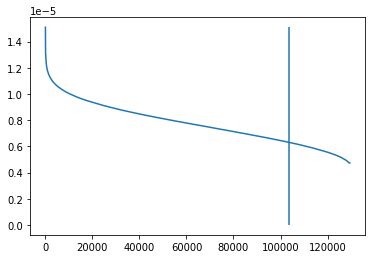

-----
Calculating scale 1
Cutting data at point 82858
Calculating scale 1 with 82858 cells


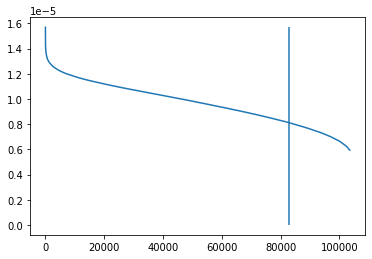

In [5]:
_humap(adata, n_scales = 2, verbose=True, subs_mode="factor", factor=0.8)

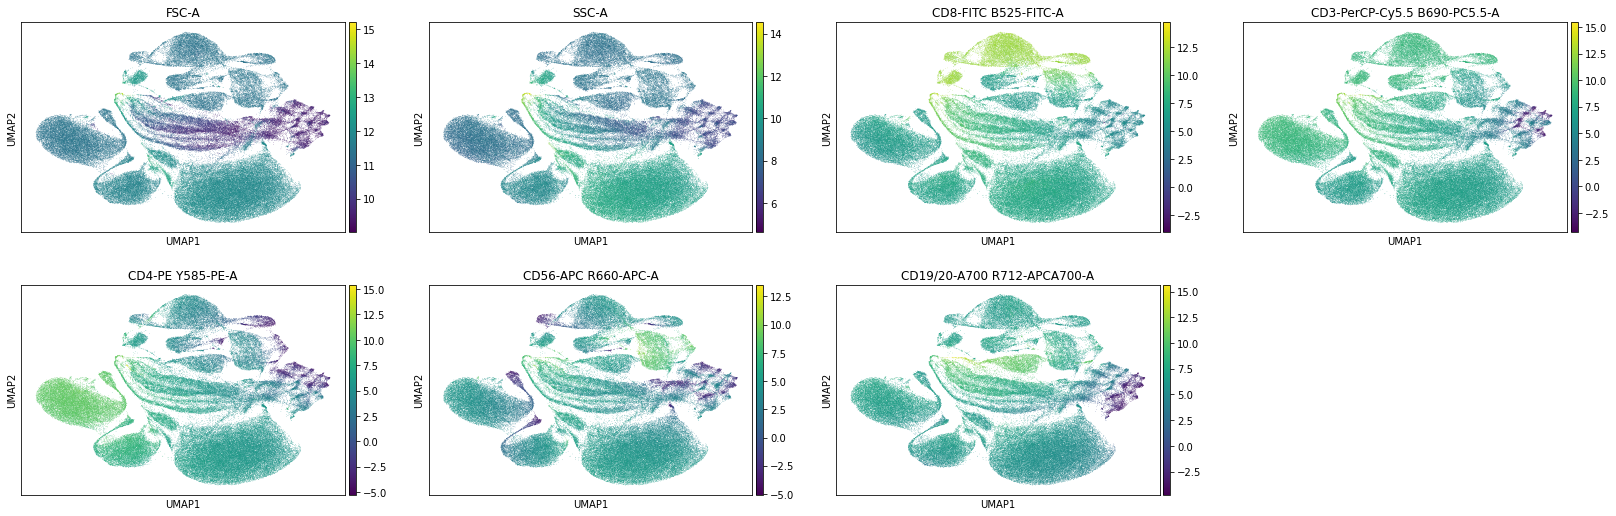

Scale 0 with 103573 cells


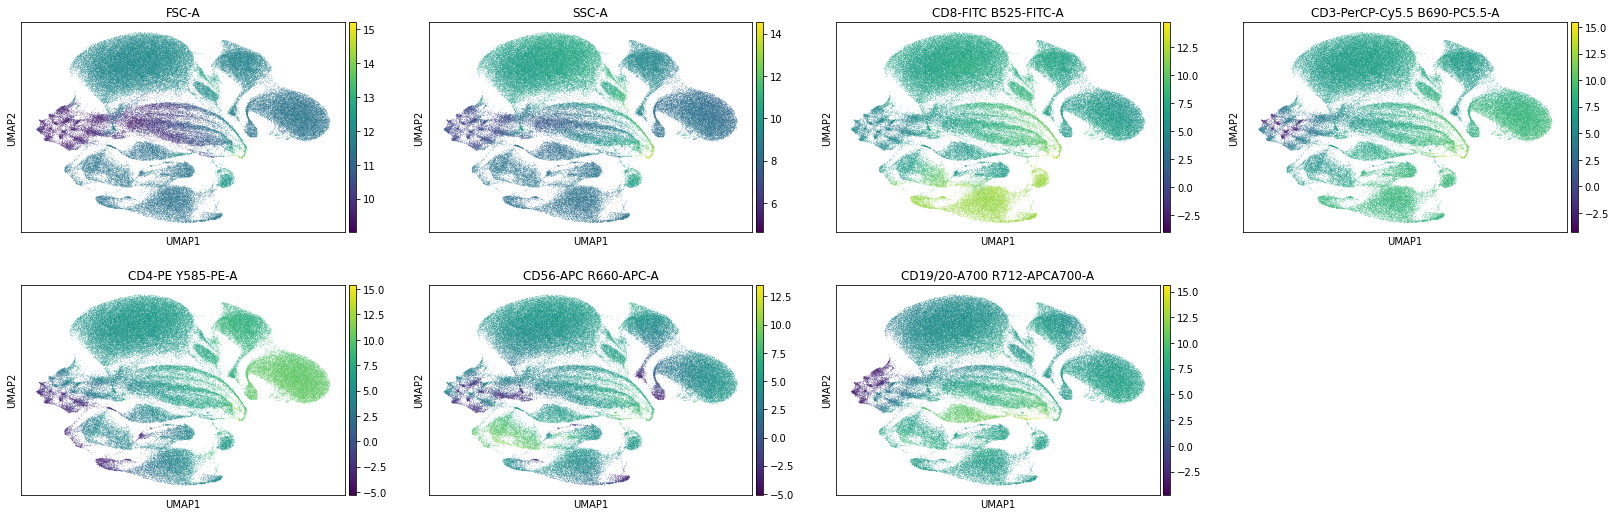

Scale 1 with 82858 cells


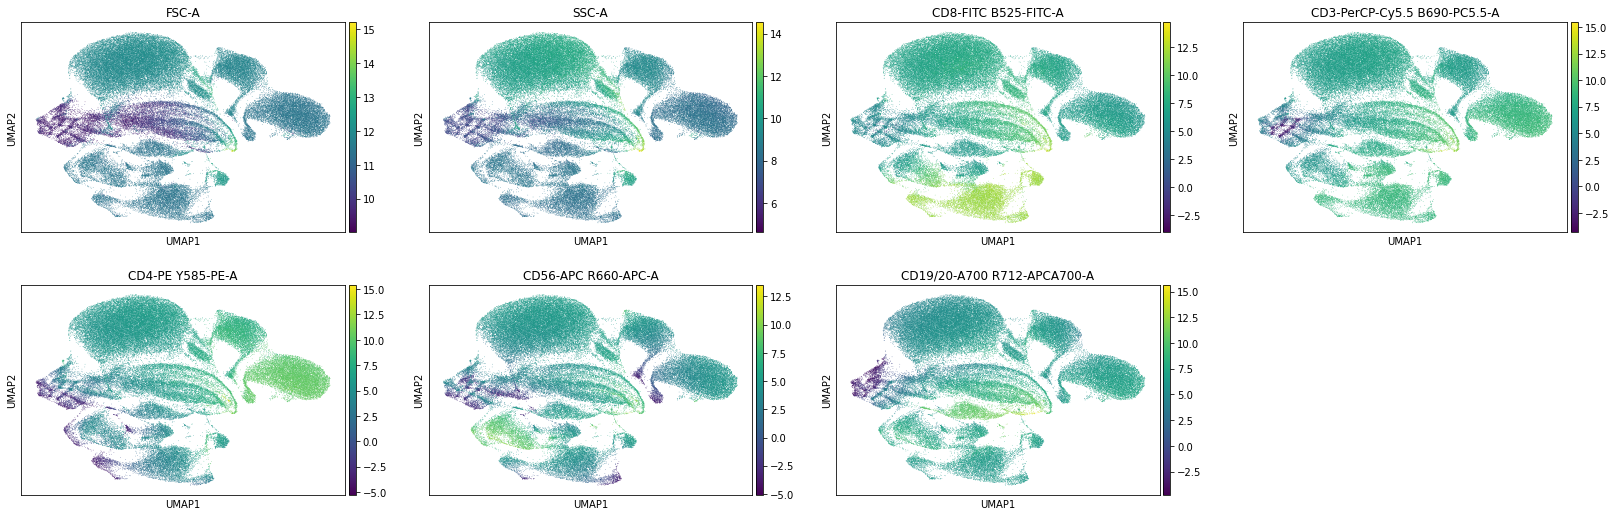

In [6]:
if 'umap' not in adata.obsm:
    sc.tl.umap(adata)
sc.pl.umap(adata, color=adata.var_names.values)
for s in enumerate(adata.uns['HUMAP_scales']):
    print(f"Scale {s[0]} with {np.shape(s[1].X)[0]} cells")
    sc.pl.umap(s[1], color=adata.var_names.values)  #[0]


**Cluster**

Louvain with resolution 0.5


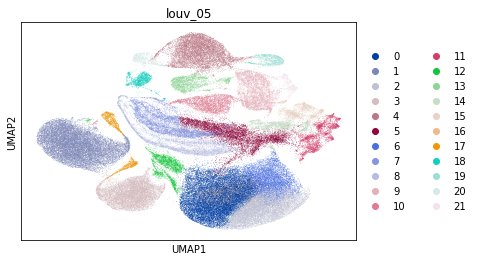

Scale 0


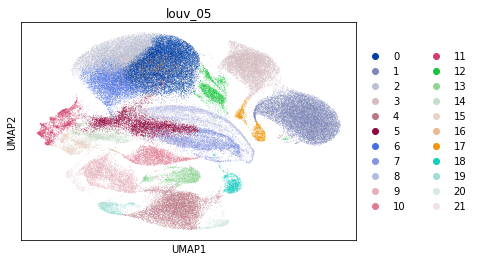

Scale 1


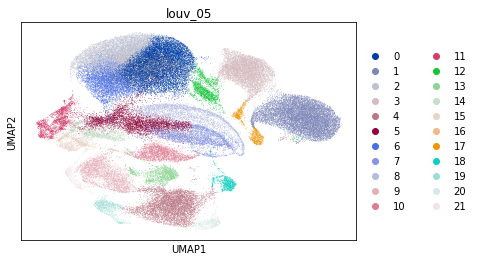

In [7]:
print("Louvain with resolution 0.5")
sc.pl.umap(adata, color="louv_05")
for s in enumerate(adata.uns['HUMAP_scales']):
    print(f"Scale {s[0]}")
    sc.pl.umap(s[1], color="louv_05")
    


**Archive**

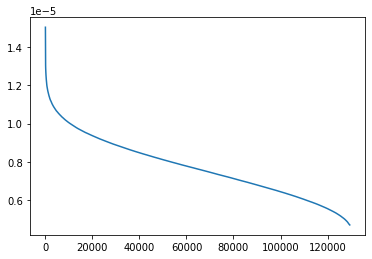

In [8]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
# concentrated

c = adata.obsp['connectivities']

T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

D, V = eigs(T.T, which='LM')

pi = V[:, 0]

pi = pi.real

pi /= pi.sum()

Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

plt.plot(pi[pi.argsort()][::-1])
plt.show()


In [9]:
from scipy.signal import medfilt

def findElbowInflectionMedian(valArray):
    infPoint = 0
    
    y = valArray
    dy = np.diff(y, n=1)
    
    if len(dy)%2 > 0:
        dy = dy[:-1]
    
    dy = medfilt(dy)
    
    print("Plotting derivative")
    plt.plot(dy)
    plt.show()
    
    # TODO why always different results?
    # TODO why not smooth? --> y is descending
    
    #infPoint = np.argmax(dy==0)
    infPoint = np.argmax(dy==max(dy))
    print(max(dy))
    
    #plt.plot(dy[:int(len(dy)/20)])
    #plt.show()
    
    ## version: CUMSUM --> cut where cumsum > 10%
    # speichi = 0
    # for i in range(len(valArray)):
    #     speichi += valArray[i]
    #     if speichi > 0.1:
    #         infPoint = i
    #         break
    
    return infPoint